In [1]:
import folium
import geemap.eefolium as gmap
import ee
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

# ee.Authenticate()
ee.Initialize()

In [2]:
Map = gmap.Map(control=True)
Map.add_child(folium.LayerControl())

In [3]:
def import_aois(csv_loc, Full_Congo_Pull=False, start_date=None,
                end_date=None, days_duration=90, poly_start=0, poly_limit=None):
    
    if Full_Congo_Pull:
        with open(csv_loc,"r",encoding='utf-8') as jsonfile:
            data = json.load(jsonfile)
            for geometry in data["features"]:
                polygon = geometry["geometry"]["coordinates"][0][0]
                poly_obj = ee.Geometry.Polygon(polygon)
                feature = ee.Feature(poly_obj)
                
        return feature



zhenya_cb_no_grid = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/congo_basin_boundary/Congo_Basin_Boundary_no_islands_v5.geojson"

In [4]:
feature = import_aois(zhenya_cb_no_grid, Full_Congo_Pull=True)

In [5]:
Full_Basin_coords = feature.getInfo()["geometry"]["coordinates"]

In [6]:
AOI_full_basin = ee.Geometry.Polygon(Full_Basin_coords)
START_DATE = '2020-01-01'
END_DATE = '2020-12-31'
CLOUD_FILTER = 100


vis = {'bands': 'array'}



def make_s2_sr_col(aoi=AOI_full_basin,start_date = START_DATE, end_date=END_DATE, CLOUD_FILTER=CLOUD_FILTER):
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))
    return s2_sr_col

def visualize_geo(coords,Map = Map):
    Map = gmap.Map()
    geo_obj = ee.Geometry.Polygon(coords)
    Map.centerObject(geo_obj,3)
    Map.add_layer(geo_obj, {}, 'default display')
    Map.add_child(folium.LayerControl())
    return Map

def visualize_raster(img):
    Map = gmap.Map()
    Map.centerObject(img,10)
    Map.addLayer(img, vis)
    Map.add_child(folium.LayerControl())
    return Map
    

In [7]:
col = make_s2_sr_col()

In [8]:
col.size().getInfo()

35283

In [12]:
# col.first().getInfo()

In [13]:
col2 = make_s2_sr_col(CLOUD_FILTER=.05)

In [14]:
col2.size().getInfo()

636

# Feature or Image Area Calculation

In [15]:
def get_area(feature):
    stateArea = feature.geometry().area()
    stateAreaSqKm = ee.Number(stateArea).divide(1e6).round()
    print(stateAreaSqKm.getInfo(),"square kilometers")
    

get_area(feature)

2508463 square kilometers


# Image Area Calculation

In [17]:
get_area(col.first())

3520 square kilometers


In [18]:
# ee.Image(col.get(2)).getInfo()

listOfImages = col2.toList(col.size())

In [77]:
# for i in range(0,20):
#     test_image = ee.Image(listOfImages.get(i))
#     get_area(test_image)

# Composite Cloud Metrics

In [20]:
cloudiness_list = col.aggregate_array('CLOUDY_PIXEL_PERCENTAGE').getInfo()

In [21]:
sum(cloudiness_list) / len(cloudiness_list)

62.86493823209461

In [22]:
df = pd.DataFrame(cloudiness_list)

In [23]:
df.value_counts()

100.000000    1424
99.999999      319
99.999997      267
99.999998      213
0.000000       158
              ... 
86.941746        1
86.946180        1
86.953259        1
86.954080        1
67.296927        1
Length: 32330, dtype: int64

In [24]:
df

,0
0,14.983846
1,71.915289
2,29.753525
3,63.559762
4,51.511392
...,...
35278,51.346035
35279,25.916541
35280,11.926514
35281,45.947831


## 8% of Basin is Moderately CloudFree Over a Two Year Period

In [25]:
df[df[0] <= 5].shape[0] / df.shape[0]

0.08295779837315422

## 4% of Basin is Relatively CloudFree Over a Two Year Period

In [26]:
df[df[0] <= 1].shape[0] / df.shape[0]

0.039622481081540685

## .4% of Basin is Completely CloudFree Over a Two Year Period

In [27]:
df[df[0] == 0].shape[0] / df.shape[0]

0.004478077261003883

## 35% of CB less than %50 cloudy Over Two Year Period

In [28]:
df[df[0] <= 50].shape[0] / df.shape[0]

0.36057024629424933

# Acquisition Cadence Stats 

In [ ]:
id_list[0].split("_")[0][:8] + id_list[0].split("_")[2]

In [29]:
id_list = col.aggregate_array('system:index').getInfo()

In [30]:
id_list[0] + id_list[1]

'20200101T082239_20200101T083245_T35MKQ20200101T082239_20200101T083245_T35MKR'

In [31]:
id_list[0].split("_")[0][:8] + id_list[0].split("_")[2]

'20200101T35MKQ'

In [32]:
date_stamps = [i.split("_")[0][:8] for i in id_list]

In [33]:
tile_ids = [i.split("_")[2] for i in id_list]

In [34]:
df = pd.DataFrame({"Date_Stamps":date_stamps,"Tile_IDs":tile_ids, "Cloudy_Percentage":cloudiness_list})

In [35]:
df

,Date_Stamps,Tile_IDs,Cloudy_Percentage
0,20200101,T35MKQ,14.983846
1,20200101,T35MKR,71.915289
2,20200101,T35MLQ,29.753525
3,20200101,T35MLR,63.559762
4,20200101,T35MLS,51.511392
...,...,...,...
35278,20201230,T32NNL,51.346035
35279,20201230,T32NNM,25.916541
35280,20201230,T32NNN,11.926514
35281,20201230,T32NPM,45.947831


In [36]:
df["Tile_IDs"].value_counts()

T35MNR    160
T35MLV    159
T35MPR    158
T35MMV    158
T34MCV    157
         ... 
T32NMK     72
T33MVT     72
T33MXR     72
T33NVG     72
T32NMN     71
Name: Tile_IDs, Length: 319, dtype: int64

In [37]:
df_cloud_free = df[df["Cloudy_Percentage"] <= 5]

In [38]:
df_cloud_free["Tile_IDs"].value_counts()

T34NFM    35
T33NTH    32
T34NHL    30
T35NME    29
T32NRN    28
          ..
T32NPK     1
T32MQV     1
T33NUB     1
T32NNK     1
T32MPA     1
Name: Tile_IDs, Length: 288, dtype: int64

In [39]:
df_means_dates = df.groupby('Date_Stamps').mean()

In [40]:
df_means_dates = df_means_dates.reset_index()

In [41]:
df_means_dates["Date_Stamps"] = pd.to_datetime(df_means_dates["Date_Stamps"])

In [42]:
df_means_monthly = df_means_dates.groupby(df_means_dates["Date_Stamps"].dt.strftime('%B'))["Cloudy_Percentage"].mean()

In [43]:
df_means_monthly = pd.DataFrame(df_means_monthly).reset_index()

In [44]:
df_means_monthly["Date_Stamps"]

0         April
1        August
2      December
3      February
4       January
5          July
6          June
7         March
8           May
9      November
10      October
11    September
Name: Date_Stamps, dtype: object

In [45]:
import datetime
months = {datetime.datetime(2000,i,1).strftime("%B"): i for i in range(1, 13)}

In [46]:
{datetime.datetime(2000,i,1).strftime("%B"): i for i in range(1, 13)}

{'January': 1,
 'February': 2,
 'March': 3,
 'April': 4,
 'May': 5,
 'June': 6,
 'July': 7,
 'August': 8,
 'September': 9,
 'October': 10,
 'November': 11,
 'December': 12}

In [47]:
df_means_monthly["month_number"] = df_means_monthly["Date_Stamps"].map(months)

In [48]:
df_means_monthly = df_means_monthly.sort_values(by=["month_number"])

# Visualization

array([[<AxesSubplot:title={'center':'Cloudy_Percentage'}>]], dtype=object)

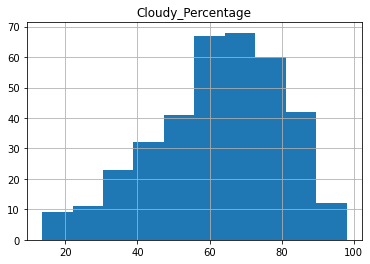

In [49]:
df_means_dates.hist()

In [50]:
df_means_dates

,Date_Stamps,Cloudy_Percentage
0,2020-01-01,32.368300
1,2020-01-02,86.328971
2,2020-01-03,82.481083
3,2020-01-04,76.161444
4,2020-01-05,58.091594
...,...,...
360,2020-12-26,63.098354
361,2020-12-27,81.604566
362,2020-12-28,49.800199
363,2020-12-29,52.430895


In [58]:
df_means_monthly = df_means_monthly[["Date_Stamps","Cloudy_Percentage"]]

In [63]:
df_means_monthly.describe()

,Cloudy_Percentage
count,12.000000
mean,62.144680
std,5.792163
min,52.454892
25%,57.820785
50%,63.376858
75%,66.988413
max,69.217994


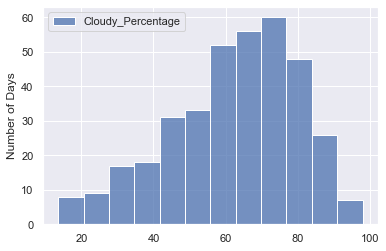

In [65]:
ax = sns.histplot(data=df_means_dates,color='c')
# plt.title("Cloudcover in the Congo Basin Rainforest in 2020", fontsize=12,fontweight="semibold")
ax.set(xlabel=None, ylabel='Number of Days')
plt.show()

In [52]:
plt.colors

AttributeError: module 'matplotlib.pyplot' has no attribute 'colors'

In [62]:
# sns.set_theme()
# ax = sns.histplot(data=df_means_monthly,color='teal')
# ax.set(xlabel="Date_Stamps")
# plt.title("Congo Basin Rainforest Cloudcover in 2020", fontsize=13,fontweight="semibold")
# plt.xticks(rotation=45)
# plt.show()

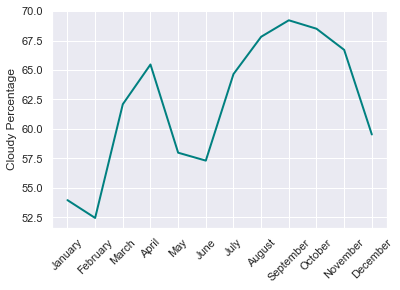

In [66]:
sns.set_theme()
ax = sns.lineplot(data=df_means_monthly, x="Date_Stamps", y="Cloudy_Percentage",color='teal',linewidth=2)
ax.set(xlabel=None, ylabel='Cloudy Percentage')
# plt.title("Congo Basin Rainforest Cloudcover in 2020", fontsize=13,fontweight="semibold")
plt.xticks(rotation=45)
plt.show()

Help on Text in module matplotlib.text object:

class Text(matplotlib.artist.Artist)
 |  Text(x=0, y=0, text='', color=None, verticalalignment='baseline', horizontalalignment='left', multialignment=None, fontproperties=None, rotation=None, linespacing=None, rotation_mode=None, usetex=None, wrap=False, **kwargs)
 |  
 |  Handle storing and drawing of text in window or data coordinates.
 |  
 |  Method resolution order:
 |      Text
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getstate__(self)
 |  
 |  __init__(self, x=0, y=0, text='', color=None, verticalalignment='baseline', horizontalalignment='left', multialignment=None, fontproperties=None, rotation=None, linespacing=None, rotation_mode=None, usetex=None, wrap=False, **kwargs)
 |      Create a `.Text` instance at *x*, *y* with string *text*.
 |      
 |      Valid keyword arguments are:
 |      
 |      Properties:
 |          agg_filter: a filter function, which takes a (m, n, 3

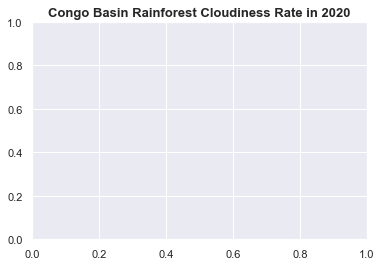

In [142]:
help(plt.title("Congo Basin Rainforest Cloudiness Rate in 2020", fontsize=13,fontweight="bold"))

In [33]:
df_means_dates

,Cloudy_Percentage
Date_Stamps,
20200101,32.368300
20200102,86.328971
20200103,82.481083
20200104,76.161444
20200105,58.091594
...,...
20201226,63.098354
20201227,81.604566
20201228,49.800199


In [98]:
df_means_dates[df_means_dates["Cloudy_Percentage"] <= 20].shape[0]

12

In [92]:
df_means_tiles = df.groupby('Tile_IDs').mean()

In [99]:
df_means_tiles[df_means_tiles["Cloudy_Percentage"] <= 20]

,Cloudy_Percentage
Tile_IDs,


In [62]:
df["Date_Stamps"].value_counts()

20200622    138
20200831    137
20190718    136
20200508    136
20200423    136
           ... 
20190923     45
20190521     45
20190522     43
20201207     43
20191127     25
Name: Date_Stamps, Length: 729, dtype: int64

In [109]:
df["Tile_IDs"].value_counts()

T34MCV    309
T35MLV    307
T35MNR    307
T35MMV    306
T34MDV    306
         ... 
T33MUP    144
T33MUS    143
T33MVU    143
T32NMN    143
T33MVT    142
Name: Tile_IDs, Length: 319, dtype: int64

In [108]:
df["Tile_IDs"].value_counts().mean()

219.73981191222572

In [110]:
pd.DataFrame(timestamps).value_counts()

20190606T34NFK    2
20190525T32NLM    2
20200828T35NPC    2
20200309T35MLS    2
20200309T35MLR    2
                 ..
20200421T34MDT    1
20200421T34MDE    1
20200421T34MDD    1
20200421T34MDC    1
20190101T32MRA    1
Length: 67246, dtype: int64

In [40]:
time_stamp_counts = pd.DataFrame(timestamps).value_counts().tolist()

In [42]:
time_stamp_counts

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [41]:
sum(time_stamp_counts) / len(time_stamp_counts)

1.0291318442732653

In [28]:
time_stamp_counts

[138,
 137,
 136,
 136,
 136,
 136,
 136,
 134,
 134,
 134,
 134,
 133,
 133,
 133,
 133,
 132,
 131,
 131,
 131,
 131,
 131,
 131,
 131,
 131,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 129,
 129,
 129,
 129,
 129,
 129,
 129,
 129,
 129,
 129,
 129,
 129,
 129,
 129,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 127,
 126,
 126,
 125,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 124,
 123,
 123,
 123,
 123,
 123,
 123,
 123,
 123,
 122,
 120,
 120,
 119,
 118,
 118,
 118,
 118,
 118,
 118,
 117,
 117,
 117,
 117,
 117,
 117,
 117,
 116,
 116,
 116,
 115,
 115,
 114,
 114,
 114

In [29]:
timestamps

['20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',
 '20190101',

# Cloudy Date Range Analysis

In [71]:
from pandas.tseries.offsets import DateOffset

In [182]:
def import_aois(csv_loc, Full_Congo_Pull=False, start_date=None,
                end_date=None, days_duration=90, poly_start=0, poly_limit=None):
    features = []
    polygons = []
    day_offset = days_duration / 2
    start_end_list = []
    
    if Full_Congo_Pull:
        with open(csv_loc,"r",encoding='utf-8') as jsonfile:
            data = json.load(jsonfile)
            for geometry in data["features"]:
                polygon = geometry["geometry"]["coordinates"][0][0]
                poly_obj = ee.Geometry.Polygon(polygon)
                feature = ee.Feature(poly_obj)
                features.append(feature)
                
            original_date = pd.to_datetime('01-01-2020')
            start = (original_date + DateOffset(days=-30))
            end = (original_date + DateOffset(days=30))
            start_date = str(start)[:10]
            end_date = str(end)[:10]
            date_dict = {
                'start_date': start_date,
                'end_date': end_date,
                'original_date': original_date,
                'day_offset': 30,
                'area': 1
            }
            
            start_end_list = [date_dict] * len(features)
            
            return ee.FeatureCollection(features), start_end_list
            
    else:
        feature_id = poly_start
        
        if poly_limit:
            df_labels = pd.read_csv(csv_loc, skiprows=range(1, poly_start+1), nrows=poly_limit)
        else:
            df_labels = pd.read_csv(csv_loc, skiprows=range(1, poly_start+1))

        df_labels = df_labels[["center-lat","center-long","polygon","Labels combined","tile date","area (km2)"]]
        df_labels["tile date"] = pd.to_datetime(df_labels["tile date"])
        start = (df_labels["tile date"] + DateOffset(days=-day_offset))
        end = (df_labels["tile date"] + DateOffset(days=day_offset))
        for i in range(len(start)):
            start_date = str(start[i])[:10]
            end_date = str(end[i])[:10]
            original_date = df_labels.loc[i, 'tile date']
            area = df_labels.loc[i, 'area (km2)']
            date_dict = {
                'start_date': start_date,
                'end_date': end_date,
                'original_date': original_date,
                'day_offset': day_offset,
                'area': area
            }
            start_end_list.append(date_dict)

        for polygon in df_labels["polygon"]:
            polygons.append(json.loads(polygon)["coordinates"])
            
        for poly in polygons:
            # create an roi. first item in Misha's label list
            feature_id += 1 
            # create geometry object, create feature object, append to features list for feature collection creation 
            polys = ee.Geometry.Polygon(poly)
            feature = ee.Feature(polys,{"name":feature_id})
            features.append(feature)
            
    return polygons
            
#         return ee.FeatureCollection(features),start_end_list,df_labels


# ### CHANGE BELOW PATH ###
zhenya_label_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v3/Polygon_List/polygons_101320.csv"
# david__label_path = 'D:/canopy_data/csvs/polygons_101320.csv'
# zhenya_tilelist_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/tile_lists/shub_tile_list/tiles_polygons_full.csv"
# david_grid_path = 'D:/canopy_data/Geometry/Congo_Basin_Shapefile_Grid_v1.geojson'
# zhenya_grid_path = '/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/tile_lists/polygon_shapefiles/Congo_Basin_Shapefile_Grid_v1.geojson'
# zhenya_grid_path_2 = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/congo_basin_boundary/Congo_Basin_Boundary_no_islands_v5_gridded.geojson"

In [184]:
# fc,date_range_list,df_labels = import_aois(zhenya_label_path, Full_Congo_Pull=False)

polygons = import_aois(zhenya_label_path, Full_Congo_Pull=False)

In [202]:
# AOI_full_basin = ee.Geometry.Polygon(Full_Basin_coords)
START_DATE = '2020-01-01'
END_DATE = '2020-12-31'
CLOUD_FILTER = 100



def make_s2_sr_col(aoi=AOI_full_basin,start_date = START_DATE, end_date=END_DATE, CLOUD_FILTER=CLOUD_FILTER):
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))
    return s2_sr_col

def make_date_range_dict(col):
    
    date_dict = {}
    
    id_list = col.aggregate_array('system:index').getInfo()
    
    date_stamps = [i.split("_")[0][:8] for i in id_list]
    
    tile_ids = [i.split("_")[2] for i in id_list]
    
    cloudiness_list = col.aggregate_array('CLOUDY_PIXEL_PERCENTAGE').getInfo()
    
    df = pd.DataFrame({"Date_Stamps":date_stamps,"Tile_IDs":tile_ids, "Cloudy_Percentage":cloudiness_list})
    
    df["Date_Stamps"] = pd.to_datetime(df["Date_Stamps"])
    
    df["month"] = df["Date_Stamps"].dt.strftime("%m")
    
    df_by_month = df.groupby("month").mean().sort_values("Cloudy_Percentage",ascending=False).reset_index()
    
    month = df_by_month.loc[0]["month"]
    
    last_day = {"01":30,
    "02":29,
    "03":31,
    "04":30,
    "05":31,
    "06":30,
    "07":31,
    "08":31,
    "09":30,
    "10":31,
    "11":30,
    "12":31}
    
    date_range_dict = {'start_date':f'2020-{month}-01','end_date':f'2020-{month}-{str(last_day[month])}'}
    
    return date_range_dict

def create_date_list(polygon_list):
    
    date_range_list = []
    
    for polygon in polygon_list:
        
        aoi = ee.Geometry.Polygon(polygon)
        
        col = make_s2_sr_col(aoi)
        
        date_range_dict =  make_date_range_dict(col)
        
        print(date_range_dict)
        
        date_range_list.append(date_range_dict)
        
    return date_range_list
    

In [203]:
date_range_list = create_date_list(polygons)

{'start_date': '2020-09-01', 'end_date': '2020-09-30'}
{'start_date': '2020-09-01', 'end_date': '2020-09-30'}
{'start_date': '2020-08-01', 'end_date': '2020-08-31'}
{'start_date': '2020-04-01', 'end_date': '2020-04-30'}
{'start_date': '2020-08-01', 'end_date': '2020-08-31'}
{'start_date': '2020-09-01', 'end_date': '2020-09-30'}
{'start_date': '2020-08-01', 'end_date': '2020-08-31'}
{'start_date': '2020-07-01', 'end_date': '2020-07-31'}
{'start_date': '2020-08-01', 'end_date': '2020-08-31'}
{'start_date': '2020-08-01', 'end_date': '2020-08-31'}
{'start_date': '2020-04-01', 'end_date': '2020-04-30'}
{'start_date': '2020-09-01', 'end_date': '2020-09-30'}


KeyboardInterrupt
2021-01-19T22:16:13Z


KeyboardInterrupt: 

In [197]:
date_range_list

[{'start_date': '2020-09-01', 'end_date': '2020-09-01'},
 {'start_date': '2020-09-01', 'end_date': '2020-09-01'},
 {'start_date': '2020-08-01', 'end_date': '2020-08-01'},
 {'start_date': '2020-04-01', 'end_date': '2020-04-01'},
 {'start_date': '2020-08-01', 'end_date': '2020-08-01'},
 {'start_date': '2020-09-01', 'end_date': '2020-09-01'},
 {'start_date': '2020-08-01', 'end_date': '2020-08-01'},
 {'start_date': '2020-07-01', 'end_date': '2020-07-01'},
 {'start_date': '2020-08-01', 'end_date': '2020-08-01'},
 {'start_date': '2020-08-01', 'end_date': '2020-08-01'},
 {'start_date': '2020-04-01', 'end_date': '2020-04-01'},
 {'start_date': '2020-09-01', 'end_date': '2020-09-01'},
 {'start_date': '2020-04-01', 'end_date': '2020-04-01'},
 {'start_date': '2020-08-01', 'end_date': '2020-08-01'},
 {'start_date': '2020-07-01', 'end_date': '2020-07-01'},
 {'start_date': '2020-07-01', 'end_date': '2020-07-01'},
 {'start_date': '2020-07-01', 'end_date': '2020-07-01'},
 {'start_date': '2020-07-01', '

In [84]:
col = make_s2_sr_col(fc.first().geometry())

In [181]:
sys_index_df(col)

{'start_date': '2020-09-01', 'end_date': '2020-09-01'}

In [169]:
df = sys_index_df(col)

In [170]:
df

,Date_Stamps,Tile_IDs,Cloudy_Percentage
0,2020-01-05,T32NNM,1.778067
1,2020-01-10,T32NNM,6.665471
2,2020-01-15,T32NNM,17.471137
3,2020-01-20,T32NNM,1.544610
4,2020-01-25,T32NNM,0.002615
...,...,...,...
66,2020-12-05,T32NNM,19.823933
67,2020-12-10,T32NNM,86.157048
68,2020-12-15,T32NNM,46.051862
69,2020-12-20,T32NNM,7.609377


In [171]:
df["month"] = df["Date_Stamps"].dt.strftime("%m")

In [174]:
df_by_month = df.groupby("month").mean().sort_values("Cloudy_Percentage",ascending=False).reset_index()

In [201]:
month

'09'

In [178]:
month = df_by_month.loc[0]["month"]

dict = {}

dic = {'start_date':f'2020-{month}-01','end_date':f'2020-{month}-01'}


In [179]:
dic

{'start_date': '2020-09-01', 'end_date': '2020-09-01'}

In [101]:
df.groupby(df["Date_Stamps"].dt.strftime('%d-%m-%Y'))["Cloudy_Percentage"].mean()

Date_Stamps
01-09-2020    99.691019
01-10-2020    74.569293
02-08-2020    99.923981
03-06-2020    76.631682
03-07-2020    95.339656
                ...    
30-01-2020     5.425963
30-03-2020    62.606284
30-11-2020    35.426358
30-12-2020    25.916541
31-10-2020    99.250107
Name: Cloudy_Percentage, Length: 71, dtype: float64

In [105]:
df.groupby(df["Date_Stamps"].dt.strftime('%B'))["Cloudy_Percentage"].mean()

Date_Stamps
April        66.127098
August       92.249418
December     37.111752
February      6.924459
January       5.481310
July         82.821552
June         72.879311
March        63.912083
May          71.632054
November     40.821373
October      78.319996
September    98.805179
Name: Cloudy_Percentage, dtype: float64

In [96]:
df.groupby('Date_Stamps').mean().sort_values("Cloudy_Percentage",ascending=False)

,Cloudy_Percentage
Date_Stamps,
2020-08-27,100.000000
2020-04-04,99.951986
2020-09-16,99.924413
2020-08-02,99.923981
2020-07-28,99.905133
...,...
2020-02-19,2.256456
2020-02-24,1.784462
2020-01-05,1.778067


In [ ]:
df_means_dates = df.groupby('Date_Stamps').mean()

# df_means_monthly = df_means_dates.groupby(df_means_dates["Date_Stamps"].dt.strftime('%B'))["Cloudy_Percentage"].mean()